In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [275]:
def preproces_tdcs(filename=None,debug=False,tdc_df=None):
    ''' 
    Args:
        filename : string
            name of the file
        debug : bool
              if True returns all dataframes
        tdc_df : pd.DataFrame Object
            instead of reading from file one can give the df directly
    Returns:
        time_df : pd.DataFrame Object
            
    It takes the data file for TDC's ONLY, which is assumed to be in the form
    TDCn: t0.
    We first seperate TDC's apart and then merge them, which creates nulls.
    The nulls for TDC2 are back filled i.e. if a cell N is null then it's filled 
    with the last cell <N which isn't null. TDC1 nulls aren't filled but rather dropped
    because we are really interested in TDC2. Finally we calculate the time difference
    between TD1 and TDC2. Finally we gate the difference by 5*10^4 ns = 50 us.
    '''
    if filename is not None:
        tpx_df =pd.read_csv(filename,
                    sep=':',
                    error_bad_lines=False,
                    warn_bad_lines=False,
                    header=None)
    elif tdc_df is not None:
        tpx_df = tdc_df
    else:
        raise(Exception('Either a filename or a tdc data frame needs to be given!'))
    tpx_df.columns = ['tdc','time']

    print('tpx_df nulls\n',tpx_df.isna().sum())
    tdc_one = tpx_df[tpx_df.tdc == 'TDC1']
    tdc_two = tpx_df[tpx_df.tdc == 'TDC2']
    time_df = tdc_one[['time']].join(tdc_two.time,how='outer',lsuffix='1',rsuffix='2')
    time_df['time2'] = time_df['time2'].fillna(method='bfill')
    time_df.dropna(inplace=True)
    time_df = time_df.astype(np.float64)
    time_df['delta_t'] = (time_df.time2-time_df.time1)*1e9
    time_df.reset_index(inplace=True)
    time_df.drop('index',axis=1,inplace=True)
    if debug:
        return tpx_df, tdc_one, tdc_two, time_df
    else:
        print(time_df.head(10))
        return time_df

In [156]:
def line_hist(df,bins=10, background=None, bg_factor = 1, linestyle=None, normalized=True):  
    '''
    Plots a histogram of the given data or signal-background. 
    Args: 
        df : List-like object
            Dataframe to be plotted
        bins : Int or List-like
            This input is the binning paramater. Either # bins or bin positions
        background : Same type as df
            background that will be subtracted
        bg_factor : Float
            If background is taken over a shorter period of time, this factor is used
            to artificially increace # hits.
        linestyle : String
            Input for the linestyle of histograms
        normalize : Bool
            controls final normalization of x,y
    Returns:
        bin_centers : np.array
            centers of bins
        y_vals : np.array
            normalized # hits
    '''
    if linestyle is None:
        linestyle ='-'
    x_vals=df
    y_vals,bin_edges= np.histogram(x_vals,bins = bins)
    bin_centers= 0.5*(bin_edges[1:]+bin_edges[:-1])
    if normalized:
        bin_centers = bin_centers-bin_centers.mean()
    if background is not None:
        x_vals2 = background
        y_vals2,_ = np.histogram(x_vals2,bins = bins)
        y_vals2 = y_vals2*bg_factor
        if normalized:
            y_out = (y_vals-y_vals2)/(y_vals-y_vals2).max()
        else:
            y_out = (y_vals-y_vals2)
        plt.plot(bin_centers,y_out, linestyle=linestyle,marker='x')
        plt.show()
        return bin_centers,y_out
    if normalized:
        y_out = y_vals/y_vals.max()
    else:
        y_out = y_vals
    plt.plot(bin_centers,y_out, linestyle=linestyle,marker='x')
    plt.show()
    return bin_centers, y_out

In [83]:
signal_df = preproces_tdcs(filename='converted7.txt')

tpx_df nulls
 tdc     0
time    0
dtype: int64
       time1     time2       delta_t
0   0.000705  0.000709   4801.306152
3   0.003526  0.003530   4790.100098
4   0.004466  0.004471   4789.587402
7   0.007287  0.007314  27138.543701
12  0.011988  0.011993   4790.887451
15  0.014809  0.014814   4789.062500
17  0.016690  0.016694   4789.324951
22  0.021391  0.021413  21853.381348
25  0.024212  0.024217   4792.187500
28  0.027033  0.027038   4790.625000


In [203]:
signal_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420357 entries, 0 to 1276057
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   time1    420357 non-null  float64
 1   time2    420357 non-null  float64
 2   delta_t  420357 non-null  float64
dtypes: float64(3)
memory usage: 12.8 MB


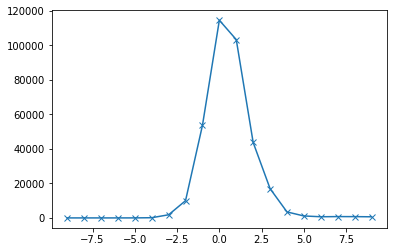

(array([-9., -8., -7., -6., -5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,
         4.,  5.,  6.,  7.,  8.,  9.]),
 array([0.00000000e+00, 8.72539439e-06, 1.74507888e-05, 1.74507888e-05,
        1.30880916e-04, 1.04704733e-03, 1.58627670e-02, 8.71143376e-02,
        4.67916725e-01, 1.00000000e+00, 9.02074899e-01, 3.81552771e-01,
        1.48131021e-01, 3.02771185e-02, 9.87714645e-03, 5.87219042e-03,
        6.73600447e-03, 6.50041882e-03, 5.67150635e-03]))

In [84]:
line_hist(signal_df.delta_t,bins=range(4780,4800))

In [85]:
background_df = preproces_tdcs(filename='converted9.txt')

tpx_df nulls
 tdc     0
time    0
dtype: int64
       time1     time2       delta_t
6   0.006612  0.006617   4788.018799
8   0.008493  0.008497   4807.812500
11  0.011313  0.011318   4790.625000
12  0.012254  0.012259   4790.881348
16  0.016015  0.016020   4790.106201
17  0.016955  0.016960   4789.324951
20  0.019776  0.019819  42802.343750
26  0.025418  0.025448  30255.731201
31  0.030120  0.030124   4805.206299
33  0.032000  0.032005   4789.587402


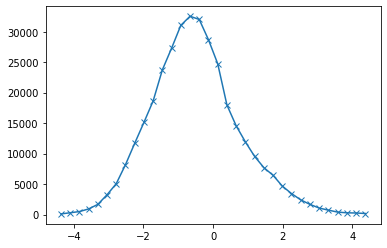

(array([-4.36764706, -4.10294118, -3.83823529, -3.57352941, -3.30882353,
        -3.04411765, -2.77941176, -2.51470588, -2.25      , -1.98529412,
        -1.72058824, -1.45588235, -1.19117647, -0.92647059, -0.66176471,
        -0.39705882, -0.13235294,  0.13235294,  0.39705882,  0.66176471,
         0.92647059,  1.19117647,  1.45588235,  1.72058824,  1.98529412,
         2.25      ,  2.51470588,  2.77941176,  3.04411765,  3.30882353,
         3.57352941,  3.83823529,  4.10294118,  4.36764706]),
 array([0.00331991, 0.00909901, 0.01512404, 0.0283422 , 0.05130491,
        0.09981249, 0.15578986, 0.25145246, 0.35934954, 0.46463373,
        0.5730534 , 0.72985767, 0.83895361, 0.95422827, 1.        ,
        0.98370785, 0.88134395, 0.76056684, 0.55242692, 0.44757308,
        0.36641972, 0.2933817 , 0.236851  , 0.19808798, 0.14373982,
        0.10596047, 0.07408318, 0.05145861, 0.0328917 , 0.02231717,
        0.01257262, 0.00891457, 0.0079309 , 0.00537948]))

In [86]:
line_hist(signal_df.delta_t,
          bins=np.linspace(4786,4795,num=35),
         )

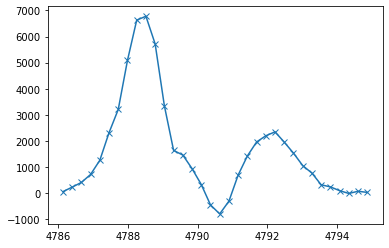

In [230]:
x_data,y_data=line_hist(signal_df.delta_t,
          bins=np.linspace(4786,4795,num=35),
          background= background_df.delta_t,
          bg_factor = 4,normalized=False
         )

In [88]:
from scipy.optimize import curve_fit

In [89]:
def fit_f(x,m1,s1,a1,m2,s2,a2):
    y = a1*np.exp(-(x-m1)**2/s1**2) + a2*np.exp(-(x-m2)**2/s2**2) 
    return y
def plot_f(m1,s1,a1,m2,s2,a2):
    x_tmp = np.linspace(-4,4,1000)
    y_tmp = fit_f(x_tmp,m1,s1,a1,m2,s2,a2)
    plt.plot(x_tmp,y_tmp)

In [90]:
fit_param, fit_cov =curve_fit(fit_f,x_data,y_data,p0=[-2, .5, 1, 2, .5, 0.4])
print('Mean1:%f\n Std1: %f\n Amp1: %f\n ---\n Mean2: %f\n Std2: %f\n Amp2: %f' % tuple(fit_param),'\n')

Mean1:-2.109158
 Std1: 0.863836
 Amp1: 0.983040
 ---
 Mean2: 1.686232
 Std2: 0.877234
 Amp2: 0.354313 



In [91]:
tuple(fit_param)

(-2.10915795249354,
 0.8638364207479595,
 0.9830396161941647,
 1.6862322990765843,
 0.8772340829615409,
 0.3543127340305918)

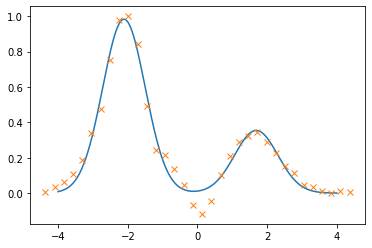

In [92]:
plot_f(*fit_param)
plt.plot(x_data,y_data,linestyle='None',marker='x')
plt.show()

In [16]:
fit_param[3]-fit_param[0]

3.7953902515701246

# TDC Stripped from Full Data

In [153]:
background2_df = preproces_tdcs('tdc11.txt')

tpx_df nulls
 tdc     0
time    0
dtype: int64
       time1     time2      delta_t
5   0.006203  0.006212  9658.331299
9   0.009964  0.009969  4808.068848
12  0.012785  0.012789  4788.800049
15  0.015605  0.015610  4789.062500
19  0.019367  0.019371  4789.587402
23  0.023128  0.023132  4789.062500
30  0.029710  0.029714  4789.318848
43  0.041933  0.041938  4789.587402
50  0.048515  0.048520  4789.843750
51  0.049455  0.049460  4790.362549


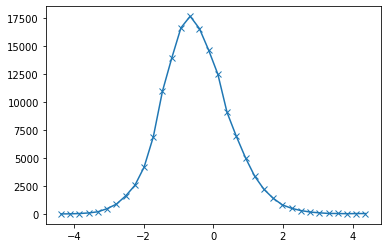

(array([-4.36764706, -4.10294118, -3.83823529, -3.57352941, -3.30882353,
        -3.04411765, -2.77941176, -2.51470588, -2.25      , -1.98529412,
        -1.72058824, -1.45588235, -1.19117647, -0.92647059, -0.66176471,
        -0.39705882, -0.13235294,  0.13235294,  0.39705882,  0.66176471,
         0.92647059,  1.19117647,  1.45588235,  1.72058824,  1.98529412,
         2.25      ,  2.51470588,  2.77941176,  3.04411765,  3.30882353,
         3.57352941,  3.83823529,  4.10294118,  4.36764706]),
 array([4.52872913e-04, 8.49136711e-04, 2.43419190e-03, 5.37786584e-03,
        1.12652137e-02, 2.70591565e-02, 4.99858477e-02, 9.10840645e-02,
        1.44466459e-01, 2.36343051e-01, 3.89527314e-01, 6.21624682e-01,
        7.87942259e-01, 9.41579394e-01, 1.00000000e+00, 9.37956411e-01,
        8.29153694e-01, 7.07104444e-01, 5.13557883e-01, 3.93376734e-01,
        2.84290971e-01, 1.90716105e-01, 1.24766487e-01, 7.95358053e-02,
        4.60232097e-02, 2.88140391e-02, 1.73789980e-02, 9.96320408e-

In [96]:
line_hist(background2_data.delta_t,bins=np.linspace(4786,4795,num=35))

In [1]:
sns.displot(data=signal[signal['delta_t']*1e9<4795],x='x',y='y',bins=100)

NameError: name 'sns' is not defined

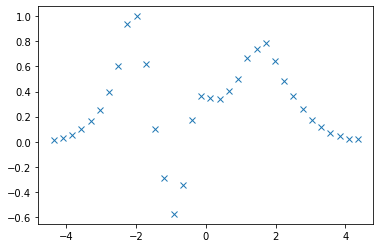

In [278]:
x_data2,y_data2=line_hist(signal2_df.delta_t,
          bins=np.linspace(4786,4795,num=35),
          background= background2_df.delta_t,
          bg_factor = 2,normalized=True,linestyle='None'
         )

In [279]:
fit_param2, fit_cov2 =curve_fit(fit_f,x_data2,y_data2,p0=[-2, .5, 1, 2, .5, 0.4])
print('Mean1:%f\n Std1: %f\n Amp1: %f\n ---\n Mean2: %f\n Std2: %f\n Amp2: %f' % tuple(fit_param),'\n')
print(fit_cov2)

Mean1:-2.109158
 Std1: 0.863836
 Amp1: 0.983040
 ---
 Mean2: 1.686232
 Std2: 0.877234
 Amp2: 0.354313 

[[ 3.23805544e-03  2.53278071e-06 -1.24783848e-06  3.89328598e-05
  -1.73184115e-04  4.59066730e-05]
 [ 2.53278071e-06  6.47948234e-03 -6.07249075e-03  9.17571499e-05
  -3.83167411e-04  1.00173713e-04]
 [-1.24783848e-06 -6.07249075e-03  1.70737790e-02 -5.01837227e-05
   1.86455957e-04 -4.74255937e-05]
 [ 3.89328598e-05  9.17571499e-05 -5.01837227e-05  1.45544436e-02
  -6.78489755e-06  1.77506172e-06]
 [-1.73184115e-04 -3.83167411e-04  1.86455957e-04 -6.78489755e-06
   2.91452810e-02 -8.55820849e-03]
 [ 4.59066730e-05  1.00173713e-04 -4.74255937e-05  1.77506172e-06
  -8.55820849e-03  7.53352369e-03]]


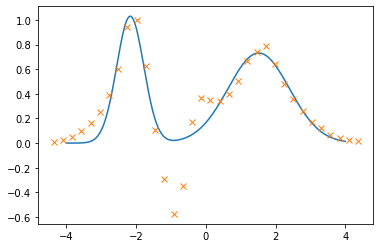

In [234]:
plot_f(*fit_param2)
plt.plot(x_data2,y_data2,linestyle='None',marker='x')
plt.show()

In [235]:
fit_param2[3]-fit_param2[0]

3.6866376240365626

# Combined Data

un stands for un-normalized

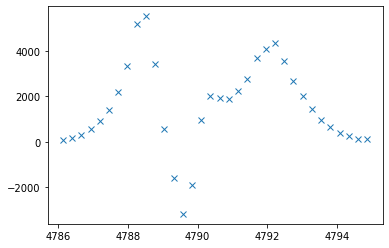

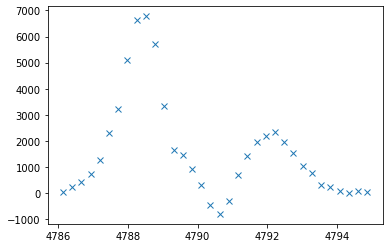

In [237]:
x_data2_un,y_data2_un=line_hist(signal2_df.delta_t,
          bins=np.linspace(4786,4795,num=35),
          background= background2_df.delta_t,
          bg_factor = 2,normalized=False,linestyle='None'
         )
x_data_un,y_data_un=line_hist(signal_df.delta_t,
          bins=np.linspace(4786,4795,num=35),
          background= background_df.delta_t,
          bg_factor = 4,normalized=False,linestyle='None'
         )

In [246]:
y_un=y_data2_un+y_data_un
y_un = y_un / y_un.max()
x_un = x_data_un-x_data_un.mean()

In [251]:
fit_param_un, fit_cov_un =curve_fit(fit_f,x_un,y_un
                                     ,p0=[-2, .5, 1, 2, .5, 0.4])
print('Mean1:%f\n Std1: %f\n Amp1: %f\n ---\n Mean2: %f\n Std2: %f\n Amp2: %f' % tuple(fit_param),'\n')
print(fit_cov_un)

Mean1:-2.109158
 Std1: 0.863836
 Amp1: 0.983040
 ---
 Mean2: 1.686232
 Std2: 0.877234
 Amp2: 0.354313 

[[ 6.69823879e-04  2.01561811e-07 -1.10187123e-07  5.19296286e-06
  -2.34951620e-05  4.92558668e-06]
 [ 2.01561811e-07  1.34007119e-03 -9.99934248e-04  1.54875129e-05
  -6.56076855e-05  1.35613737e-05]
 [-1.10187123e-07 -9.99934248e-04  2.23812101e-03 -8.82136260e-06
   3.57051684e-05 -7.30582179e-06]
 [ 5.19296286e-06  1.54875129e-05 -8.82136260e-06  4.23965483e-03
  -9.16239108e-07  1.89647417e-07]
 [-2.34951620e-05 -6.56076855e-05  3.57051684e-05 -9.16239108e-07
   8.48325314e-03 -1.96556046e-03]
 [ 4.92558668e-06  1.35613737e-05 -7.30582179e-06  1.89647417e-07
  -1.96556046e-03  1.36588078e-03]]


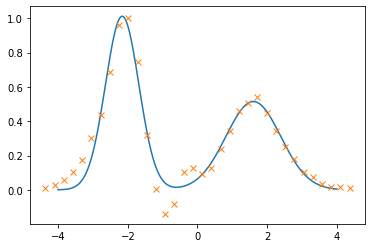

In [248]:
plot_f(*fit_param_un)
plt.plot(x_un,y_un,linestyle='None',marker='x')
plt.show()

In [249]:
fit_param_un[3]-fit_param_un[0]

3.764383397803491

In [3]:
a=pd.read_csv('tdc8.txt')

In [4]:
len(a)

2957354